In [1]:
# import modules
import numpy as np

# import plotting modules
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from IPython.display import Latex

%matplotlib inline

from matplotlib import gridspec
from NFW_Z import NFW_Z

## NOTE: The following code uses the ENCLOSED density within spherical shells.

In [2]:
class AvDensProf:
    
    
    def __init__(self, Mv):
        
        """Initiate the class with a known virial mass of the halo.
        Input: virial mass in solar masses."""
        
        self.Mvir = Mv


    def find_dens_profile(self, raw_radius_data, radius_array, bin_size):
        
        """Derive an AVERAGE dark matter density profile from raw data.
        Inputs:
        1) raw_radius_data: array of the radii at which dark matter particles are found, based on provided data.
        2) radius_array: array of the radii of imaginary spherical shells centered on the galactic center.
        3) bin_size: integer that best matches the image resolution.
        Output: density_profile (the AVERAGE dark matter density profile of the data)"""
        
        density_profile = np.zeros(np.size(radius_array))
        i = 0
        for radius_value in radius_array: # enclosed density
            particles = np.where((raw_radius_data < (radius_value + bin_size)))
            how_many_particles = np.size(particles)
            shell_volume = 4/3*np.pi*((radius_value + bin_size)**3)
            density_profile[i] = how_many_particles / shell_volume * 500 #500 is 500 M_Sun, the mass per particle
            i += 1
        return density_profile
    
    
    def extension(self, starting_radius, upper_limit_guess, bin_size):
        
        """If the SUBFIND virial radius isn't correct, the researcher can use this one to create
        an extended radius array that covers the region where they think the actual virial radius
        should be.
        Inputs:
        1) starting_radius: where to begin the array
        2) upper_limit_guess: where to end the array
        3) bin_size: how big each increment is between two elements of the array.
        Output: extended_array (the extended radius array)"""
        
        extended_array = np.arange(starting_radius, upper_limit_guess, bin_size)
        return extended_array
    
    
    def deriving_r200(self, rho_crit, starting_radius, upper_limit_guess, bin_size, numerator, addition):
        
        """Using the extended radius array from extension, this function generates an extended density profile
        that's shaped like the graph of 1/x^3, then finds the radius on the extended radius array that best
        matches a density equal to 200 times the critical density on the density array. 
        Inputs:
        1) rho_crit: the critical density in this specific case.
        2) upper_limit_guess: where to end the array
        3) bin_size: how big each increment is between two elements of the array.
        4) numerator: the numerator that would give the best extended density profile plot
        5) addition: the addition to the denominator that would give the best extended density profile plot
        Output: rad200 (the radius where the density best matches 200 times rho_crit)"""
        
        # extract the extended radius array from extension
        extended_array = self.extension(starting_radius, upper_limit_guess, bin_size)
        
        # use the extended radius array to make an extended density profile
        extended_dens_prof = numerator / (extended_array**3 + addition)        
        deviation = np.abs(extended_dens_prof - rho_crit*200)
        least_difference_index = deviation.argmin()
        rad200 = extended_array[least_difference_index]
        return rad200
        
        
    def deriving_r_RDO(self, rho_crit, starting_radius, rho_delta_omega, upper_limit_guess, bin_size, numerator, addition):

        """Using the extended radius array from extension, this function generates an extended density profile
        that's shaped like the graph of 1/x^3, then finds the radius on the extended radius array that best
        matches a density equal to rho_crit * delta_vir * Omega_M. 
        Inputs:
        1) rho_crit: the critical density in this specific case.
        2) rho_delta_omega: rho_crit * delta_vir * Omega_M. This value is dependent on the redshift observed.
        3) upper_limit_guess: where to end the array
        4) bin_size: how big each increment is between two elements of the array.
        5) numerator: the numerator that would give the best extended density profile plot
        6) addition: the addition to the denominator that would give the best extended density profile plot
        Output: rad_rdo (the radius where the density best matches rho_crit * delta_vir * Omega_M)"""
        
        extended_array = self.extension(starting_radius, upper_limit_guess, bin_size)
        extended_dens_prof = numerator / (extended_array**3 + addition)        
        difference = abs(extended_dens_prof - rho_delta_omega)
        smallest_diff_index = difference.argmin()
        rad_rdo = extended_array[smallest_diff_index]
        return rad_rdo
    
    
    def find_mass_profile(self, raw_radius_data, radius_array, bin_size):
        
        """Derive a dark matter particle mass profile from raw data.
        Inputs:
        1) raw_radius_data: array of the radii at which dark matter particles are found, based on provided data.
        2) radius_array: array of the radii of imaginary spherical shells centered on the galactic center.
        3) bin_size: integer that best matches the image resolution.
        Output: the dark matter particle mass profile."""
        
        mass_profile = np.zeros(np.size(radius_array))
        h = 0
        for radius_value in radius_array: # enclosed density
            particles_at_a_location = np.where((raw_radius_data < (radius_value + bin_size)))
            how_many_particles = np.size(particles_at_a_location)
            mass_profile[h] = how_many_particles * 500 #500 is 500 M_Sun, the mass per particle
            h += 1
        return mass_profile
        
        
    def final_plot(self, starting_radius, bin_size, raw_radius_data, radius_array, upper_limit_guess, \
                   quoted_Rvir, redshift, numerator, addition):
        
        """This function generates the final plot, with the AVERAGE density profile based on provided data,
        the EXTENDED density profile, as well as two pairs of similarly colored horizontal and vertical lines.
        Inputs:
        1) starting_radius: where to begin the radius array. Unit: kpc
        2) bin_size: how big each increment is between two elements of the radius array. Unit: kpc
        3) raw_radius_data: array of the radii at which dark matter particles are found, based on provided data.
        4) radius_array: array of the radii of imaginary spherical shells centered on the galactic center.
        5) upper_limit_guess: where to end the radius array. Unit: kpc
        6) quoted_Rvir: the virial radius quoted in the data. Unit: kpc
        7) redshift: the redshift at which the dwarf is observed.
        8) numerator: the numerator that would give the best extended density profile plot
        9) addition: the addition to the denominator that would give the best extended density profile plot
        Output: the final plot."""
        
        # extract the density profile array from find_dens_profile
        density_profile = self.find_dens_profile(raw_radius_data, radius_array, bin_size)
        
        # extract the extended radius array from extension and make an extended density profile based on it
        extended_array = self.extension(starting_radius, upper_limit_guess, bin_size)
        extended_dens_prof = numerator / (extended_array**3 + addition)
        
        # extract the total particle mass of the data
        massprof = self.find_mass_profile(raw_radius_data, radius_array, bin_size) 
        old_Mvir = self.find_mass_profile(raw_radius_data, radius_array, bin_size)[np.size(massprof) - 1]
        
        # get rho_crit, rho_delta and rho_delta_omega from the NFW_Z code
        NFW = NFW_Z(old_Mvir, 'Jeon')
        rho_crit = NFW.rho_crit(redshift)
        rho_delta = rho_crit * NFW.delta_vir(redshift)
        rho_delta_omega = rho_crit * NFW.delta_vir(redshift) * NFW.OmegaM_Z(redshift)
        
        # extract rad200 from deriving_r200
        rad200 = self.deriving_r200(rho_crit, starting_radius, upper_limit_guess, bin_size, numerator, addition)

        # extract rad_rdo from deriving r_RDO
        rad_rdo = self.deriving_r_RDO(rho_crit, starting_radius, rho_delta_omega, upper_limit_guess, bin_size, \
                                      numerator, addition)
                
        # we all know what this is
        fig, ax = plt.subplots(figsize=[10, 10])
        
        # plot the AVERAGE density profile based on data. 
        # this line will be purple.
        plt.plot(radius_array, density_profile, color=(0.5, 0.1, 0.9, 1), linewidth=2, \
                 label="average density profile based on data")
        
        # plot the radius (and corresponding density) where the density best matches rho_crit * delta_vir.
        # these lines will be cyan.
        plt.axhline(rho_delta, color='#23B5D3', linewidth=2, \
                   label="HORIZONTAL: $ρ_{crit}$ x $Δ_{vir}$" + \
                    "\nVERTICAL: quoted $r_{vir}$: " + str(round(quoted_Rvir, 2)) + ' kpc')
        plt.axvline(quoted_Rvir, color='#23B5D3', linewidth=2)

        # plot the extended density profile
        plt.plot(extended_array, extended_dens_prof, color='#2B4570', linestyle='-.')

        # plot the radius (and corresponding density) where the density best matches rho_crit * 200
        # these lines will be red.
        plt.axhline(rho_crit * 200, color='#EA526F', linewidth=2, \
                   label="HORIZONTAL: $ρ_{crit}$ x 200" + "\nVERTICAL: $r_{200}$ = " + str(round(rad200, 2)) + " kpc")
        plt.axvline(rad200, color='#EA526F', linewidth=2)

        # plot the radius (and corresponding density) where the density best matches rho_crit * delta_vir * Omega_M.
        # these lines will be grey.
        plt.axhline(rho_delta_omega, color='#D0CFCF', linewidth=2, \
                   label="HORIZONTAL: $ρ_{crit}$ x $Δ_{vir}$ x $\Omega_{M}$" + \
                   '\nVERTICAL: actual $r_{vir}$ needed: ' + str(rad_rdo) + ' kpc')
        plt.axvline(rad_rdo, color='#D0CFCF', linewidth=2)

        # plot the points of intersection
        plt.plot(quoted_Rvir, rho_delta, 'o', color='#23B5D3')
        plt.plot(rad200, rho_crit * 200, 'o', color='#EA526F')
        plt.plot(rad_rdo, rho_delta_omega, 'o', color='#D0CFCF')

        # this deals with the legends and the rest
        plt.legend(bbox_to_anchor=(1.02, 1.01), loc='upper left')
        plt.xlabel('distance from galactic center (kpc)', fontsize=17)
        plt.ylabel('average dark matter density ($M_\odot$/kpc$^3$)', fontsize=17) # using LATEX here!
        plt.title('Plot Title', loc='center', fontsize=17)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xscale('log')
        plt.yscale('log')    

        # lo and behold!
        plt.show()

## test 1: dwarf 1, RT

In [3]:
dm_300 = np.loadtxt("D:/Research/ultra-faint dwarf galaxies/velocity/dwarf1/RT/dwarf_dm_5e8_rt_0300.txt")

dx_dm_300 = dm_300[:,4] / 1000 # converting pc to kpc
dy_dm_300 = dm_300[:,5] / 1000 # converting pc to kpc
dz_dm_300 = dm_300[:,6] / 1000 # converting pc to kpc
r_dm_300 = np.sqrt(dx_dm_300**2 + dy_dm_300**2 + dz_dm_300**2)

generated_array = np.arange(0.01, 11.7, 0.02)

Jeon_Rvir_1_RT = 1.1701e+04 * 0.001 # in kpc
Jeon_Mvir_1_RT = 1.9122e+08 # in solar masses

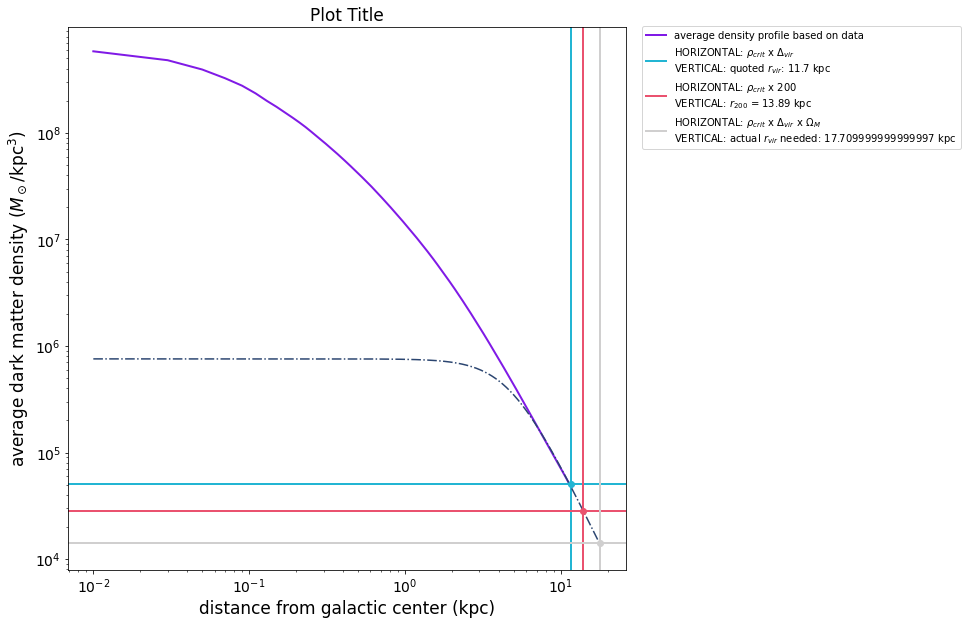

In [4]:
d1_RT = AvDensProf(Jeon_Mvir_1_RT)

d1_RT.final_plot(0.01, 0.02, r_dm_300, generated_array, 18, Jeon_Rvir_1_RT, 0.024, 10**7.9, 105)

## test 2: dwarf 1, no RT

In [5]:
dm_290_noRT = np.loadtxt("D:/Research/ultra-faint dwarf galaxies/velocity/dwarf1/noRT/dwarf_dm_5e8_0290.txt")

dx_dm_290_noRT = dm_290_noRT[:,4] / 1000 # converting pc to kpc
dy_dm_290_noRT = dm_290_noRT[:,5] / 1000 # converting pc to kpc
dz_dm_290_noRT = dm_290_noRT[:,6] / 1000 # converting pc to kpc
r_dm_290_noRT = np.sqrt(dx_dm_290_noRT**2 + dy_dm_290_noRT**2 + dz_dm_290_noRT**2)

generated_array_1_noRT = np.arange(0.01, 11.3, 0.02)

Jeon_Rvir_1_noRT = 1.1334e+04 * 0.001 # in kpc
Jeon_Mvir_1_noRT = 1.9030e+08 # in solar masses

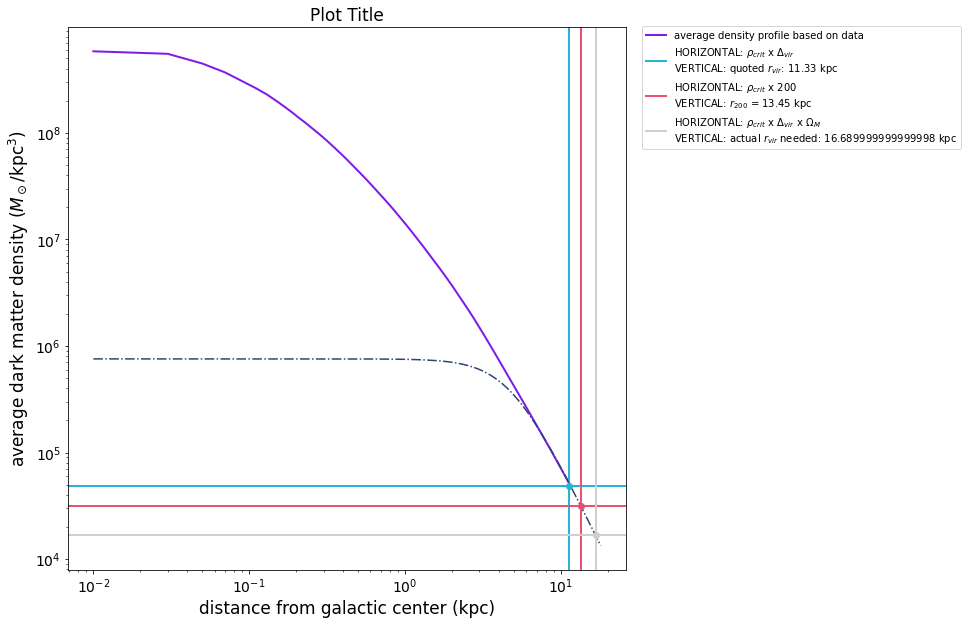

In [6]:
d1_noRT = AvDensProf(Jeon_Mvir_1_noRT)

d1_noRT.final_plot(0.01, 0.02, r_dm_290_noRT, generated_array_1_noRT, 18, Jeon_Rvir_1_noRT, 0.130, 10**7.9, 105)

# test 3: dwarf 2, RT

In [7]:
dm_300_RT = np.loadtxt("D:/Research/ultra-faint dwarf galaxies/velocity/dwarf2/RT/dwarf_dm_7e8_rt_0300.txt")

dx_dm_300_RT = dm_300_RT[:,4] / 1000 # converting pc to kpc
dy_dm_300_RT = dm_300_RT[:,5] / 1000 # converting pc to kpc
dz_dm_300_RT = dm_300_RT[:,6] / 1000 # converting pc to kpc
r_dm_300_RT = np.sqrt(dx_dm_300_RT**2 + dy_dm_300_RT**2 + dz_dm_300_RT**2)

generated_array_2_RT = np.arange(0.01, 9.73, 0.02)

Jeon_Rvir_2_RT = 9.7296e+03 * 0.001 # in kpc
Jeon_Mvir_2_RT = 1.0999e+08 # in solar masses

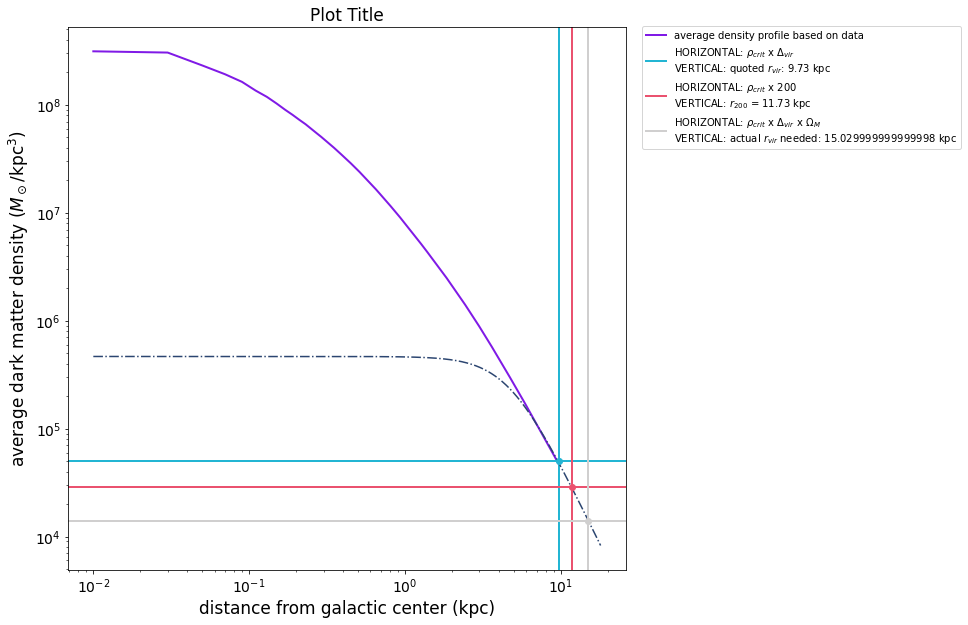

In [8]:
d2_RT = AvDensProf(Jeon_Mvir_2_RT)

d2_RT.final_plot(0.01, 0.02, r_dm_300_RT, generated_array_2_RT, 18, Jeon_Rvir_2_RT, 0.024, 10**7.69, 105)